In [1]:
# label -> onehot

In [2]:
import os
import time
import skimage.io
import numpy as np
import pandas as pd
# import cv2
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
from efficientnet_pytorch import model as enet
import albumentations
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from tqdm import tqdm
from skimage.transform import rescale, resize
from PIL import Image


In [3]:
DEBUG=False

In [4]:
data_dir = './PANDA_data/'
df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
# df=df[df['data_provider']=='radboud'].reset_index(drop=True)

image_folder = os.path.join(data_dir, 'train_images')
df_gleason=pd.read_csv('pred_gleason.csv')
kernel_type = 'train_isup_base_copy'

enet_type = 'efficientnet-b0'
fold = 0
tile_size = 256
image_size =1536
n_tiles = 36
batch_size = 6
num_workers = 6
out_dim = 5
init_lr = 3e-4
# init_lr=3e-3
warmup_factor = 10

warmup_epo = 1
n_epochs = 10 if DEBUG else 10
df = df.sample(100).reset_index(drop=True) if DEBUG else df

gpu_id = 1
device = torch.device(f'cuda:{gpu_id}')

print(image_folder)

./PANDA_data/train_images


In [5]:
skf = StratifiedKFold(5, shuffle=True, random_state=42)
df['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df, df['isup_grade'])):
    df.loc[valid_idx, 'fold'] = i
df.head()

,image_id,data_provider,isup_grade,gleason_score,fold
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,4
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,3
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,4


In [6]:
pretrained_model = {
    'efficientnet-b0': 'efficientnet-b0-08094119.pth'
}

In [7]:
class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        self.enet.load_state_dict(torch.load(pretrained_model[backbone]))

        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x

In [8]:
def padding_img(img_tmp,crop_size):
        pad=crop_size-img_tmp.shape[0]
        pad=np.full((pad,img_tmp.shape[1],img_tmp.shape[2]),255)
        img_tmp=np.concatenate([img_tmp,pad],axis=0)
        pad=crop_size-img_tmp.shape[1]
        pad=np.full((img_tmp.shape[0],pad,img_tmp.shape[2]),255)
        img_tmp=np.concatenate([img_tmp,pad],axis=1)
        return img_tmp

def tile_map(image,idx1,idx2,crop_size=1024):
    res_img=np.full((image_size,image_size,3),255)
    cnt=0
    for i,j in zip(idx1,idx2):                    
        tmp=image[i*crop_size:(i+1)*crop_size,j*crop_size:(j+1)*crop_size,:]
        if tmp.shape[0]<crop_size or tmp.shape[1]<crop_size:
            tmp=padding_img(tmp,crop_size)
        tmp=Image.fromarray(tmp.astype('uint8'))
        tmp=tmp.resize((tile_size,tile_size))
        tmp=np.array(tmp)
        tile_idx1=cnt//int(np.sqrt(n_tiles))
        tile_idx2=cnt%int(np.sqrt(n_tiles))
        res_img[tile_idx1*tile_size:(tile_idx1+1)*tile_size,tile_idx2*tile_size:(tile_idx2+1)*tile_size]=tmp
        
        cnt+=1
    return res_img

In [9]:
class PANDADataset(Dataset):
    def __init__(self,
                 df,
                 tile_gleason,
                 image_size,
                 rand=False,
                 transform=None,
                ):

        self.df = df.reset_index(drop=True)
        self.tile_gleason=tile_gleason
        self.image_size = image_size
        self.rand = rand
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        
        tmp_df=self.tile_gleason[self.tile_gleason['image_id']==img_id].sort_values(by=['gleason'],ascending=False)
        idx1=tmp_df['idx1'].values[:n_tiles]
        idx2=tmp_df['idx2'].values[:n_tiles]
        
        image = skimage.io.MultiImage(os.path.join(image_folder,img_id)+'.tiff')[0]
            
        try:
            image=tile_map(image,idx1,idx2)
        except:
            print(img_id)
        image=np.asarray(image)

        if self.transform is not None:
            image = self.transform(image=image)['image']
        image = image.astype(np.float32)
        image /= 255
        image = image.transpose(2, 0, 1)

        label = np.zeros(5).astype(np.float32)
        label[:row.isup_grade] = 1.
#         label=np.array(row.isup_grade).astype(int)
        return torch.tensor(image), torch.tensor(label)



In [10]:
transforms_train = albumentations.Compose([
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
])
transforms_val = albumentations.Compose([])

In [11]:
df[df['image_id'].isin(df_gleason['image_id'].values)]

,image_id,data_provider,isup_grade,gleason_score,fold
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,4
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,3
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,4
...,...,...,...,...,...
10611,ffd2841373b39792ab0c84cccd066e31,radboud,0,negative,2
10612,ffdc59cd580a1468eac0e6a32dd1ff2d,radboud,5,4+5,2
10613,ffe06afd66a93258f8fabdef6044e181,radboud,0,negative,1
10614,ffe236a25d4cbed59438220799920749,radboud,2,3+4,1


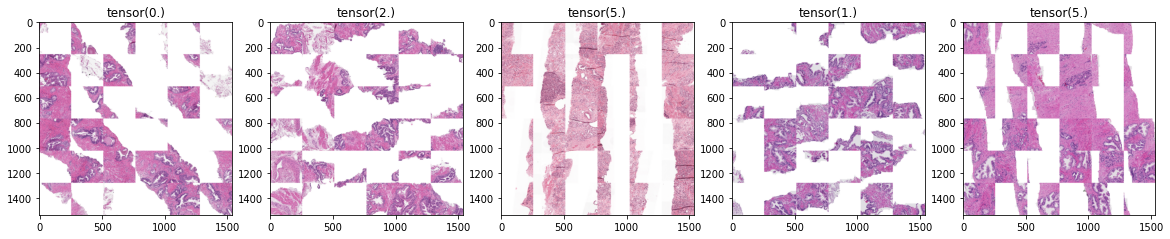

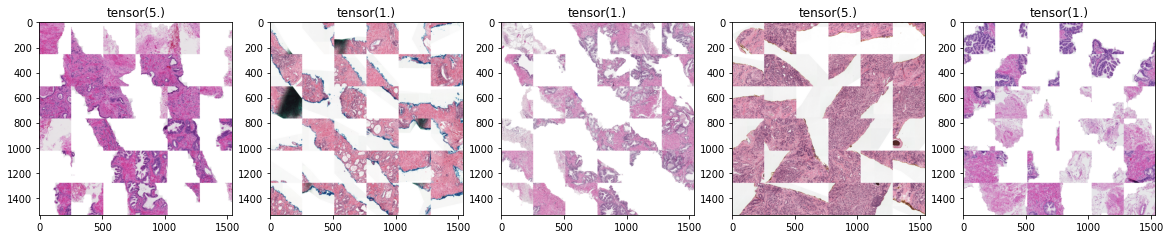

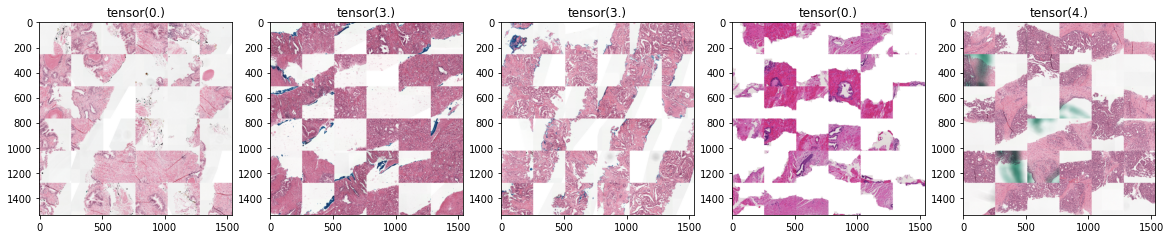

In [12]:
dataset_show = PANDADataset(df,df_gleason,image_size, transform=transforms_train)
# dataset_show = PANDADataset(df[df['image_id'].isin(df_gleason['image_id'].values)],df_gleason,image_size, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(3):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(str(sum(label)))
#         axarr[p].set_title(str(np.array(label).astype(int)))


In [13]:
criterion = nn.BCEWithLogitsLoss()
# criterion=nn.CrossEntropyLoss()

In [14]:
# def train_epoch(loader, optimizer):

#     model.train()
#     train_loss = []
#     bar = tqdm(loader)
#     for (data, target) in bar:
        
#         data, target = data.to(device), target.to(device)
#         loss_func = criterion
#         optimizer.zero_grad()
#         logits = model(data)
#         loss = loss_func(logits, target)
#         loss.backward()
#         optimizer.step()

#         loss_np = loss.detach().cpu().numpy()
#         train_loss.append(loss_np)
#         smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
#         bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
#     return train_loss


# def val_epoch(loader, get_output=False):

#     model.eval()
#     val_loss = []
#     LOGITS = []
#     PREDS = []
#     TARGETS = []

#     with torch.no_grad():
#         for (data, target) in tqdm(loader):
#             data, target = data.to(device), target.to(device)
#             logits = model(data)
#             loss = criterion(logits, target)

#             # pred = logits.sigmoid().detach()
#             pred=logits.argmax(1).detach()
#             LOGITS.append(logits)
#             PREDS.append(pred)
#             TARGETS.append(target)

#             val_loss.append(loss.detach().cpu().numpy())
#         val_loss = np.mean(val_loss)

#     LOGITS = torch.cat(LOGITS).cpu().numpy()
#     PREDS = torch.cat(PREDS).cpu().numpy()
#     TARGETS = torch.cat(TARGETS).cpu().numpy()
#     acc = (PREDS == TARGETS).mean()
    
#     qwk = cohen_kappa_score(PREDS, TARGETS, weights='quadratic')

#     if get_output:
#         return LOGITS
#     else:
#         return val_loss, acc, qwk

    

In [15]:
def train_epoch(loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        
        data, target = data.to(device), target.to(device)
        loss_func = criterion
        optimizer.zero_grad()
        logits = model(data)
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss


def val_epoch(loader, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)

            loss = criterion(logits, target)

            pred = logits.sigmoid().sum(1).detach().round()
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(target.sum(1))

            val_loss.append(loss.detach().cpu().numpy())
        val_loss = np.mean(val_loss)

    LOGITS = torch.cat(LOGITS).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    acc = (PREDS == TARGETS).mean() * 100.
    
    qwk = cohen_kappa_score(PREDS, TARGETS, weights='quadratic')
    qwk_k = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'karolinska'], df_valid[df_valid['data_provider'] == 'karolinska'].isup_grade.values, weights='quadratic')
    qwk_r = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'radboud'], df_valid[df_valid['data_provider'] == 'radboud'].isup_grade.values, weights='quadratic')
    print('qwk', qwk, 'qwk_k', qwk_k, 'qwk_r', qwk_r)

    if get_output:
        return LOGITS
    else:
        return val_loss, acc, qwk

    

In [16]:
train_idx = np.where((df['fold'] != fold))[0]
valid_idx = np.where((df['fold'] == fold))[0]

df_this  = df.loc[train_idx]
df_valid = df.loc[valid_idx]

dataset_train = PANDADataset(df_this , df_gleason, image_size, transform=transforms_train)
dataset_valid = PANDADataset(df_valid, df_gleason, image_size, transform=transforms_val)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train), num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=SequentialSampler(dataset_valid), num_workers=num_workers)

model = enetv2(enet_type, out_dim=out_dim)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=init_lr/warmup_factor)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs-warmup_epo)
scheduler = GradualWarmupScheduler(optimizer, multiplier=warmup_factor, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

print(len(dataset_train), len(dataset_valid))

8492 2124


In [17]:
qwk_max = 0.
best_file = f'{kernel_type}_best_fold{fold}.pth'
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)
    scheduler.step(epoch-1)

    train_loss = train_epoch(train_loader, optimizer)
    val_loss, acc, qwk = val_epoch(valid_loader)

    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(acc):.5f}, qwk: {(qwk):.5f}'
    print(content)
    with open(f'log_{kernel_type}.txt', 'a') as appender:
        appender.write(content + '\n')

    if qwk > qwk_max:
        print('score2 ({:.6f} --> {:.6f}).  Saving model ...'.format(qwk_max, qwk))
        torch.save(model.state_dict(), best_file)
        qwk_max = qwk

torch.save(model.state_dict(), os.path.join(f'{kernel_type}_final_fold{fold}.pth'))

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

Sun Jul  5 04:05:14 2020 Epoch: 1


  0%|          | 0/1416 [00:00<?, ?it/s]

qwk 0.7485477839081526 qwk_k 0.698504237679314 qwk_r 0.7183162739020705
Sun Jul  5 05:24:44 2020 Epoch 1, lr: 0.0000300, train loss: 0.41625, val loss: 0.30673, acc: 38.88889, qwk: 0.74855
score2 (0.000000 --> 0.748548).  Saving model ...
Sun Jul  5 05:24:44 2020 Epoch: 2


  0%|          | 0/1416 [00:00<?, ?it/s]

qwk 0.8163646870960384 qwk_k 0.7960205107317226 qwk_r 0.7839045271442118
Sun Jul  5 06:26:10 2020 Epoch 2, lr: 0.0003000, train loss: 0.34955, val loss: 0.29900, acc: 53.86064, qwk: 0.81636
score2 (0.748548 --> 0.816365).  Saving model ...
Sun Jul  5 06:26:10 2020 Epoch: 3


  0%|          | 0/1416 [00:00<?, ?it/s]

qwk 0.8372174206030648 qwk_k 0.819406149393698 qwk_r 0.8055274268568111
Sun Jul  5 07:25:07 2020 Epoch 3, lr: 0.0000300, train loss: 0.27605, val loss: 0.24222, acc: 59.69868, qwk: 0.83722
score2 (0.816365 --> 0.837217).  Saving model ...
Sun Jul  5 07:25:07 2020 Epoch: 4


  0%|          | 0/1416 [00:00<?, ?it/s]

qwk 0.8272395350739836 qwk_k 0.8193978407387981 qwk_r 0.7778437561325339
Sun Jul  5 08:20:45 2020 Epoch 4, lr: 0.0002649, train loss: 0.28736, val loss: 0.25088, acc: 57.62712, qwk: 0.82724
Sun Jul  5 08:20:45 2020 Epoch: 5


  0%|          | 0/1416 [00:00<?, ?it/s]

qwk 0.8175732820743065 qwk_k 0.8066102233979318 qwk_r 0.7777384889904162
Sun Jul  5 09:16:00 2020 Epoch 5, lr: 0.0002250, train loss: 0.25286, val loss: 0.25288, acc: 61.29944, qwk: 0.81757
Sun Jul  5 09:16:00 2020 Epoch: 6


  0%|          | 0/1416 [00:00<?, ?it/s]

qwk 0.8120626862302176 qwk_k 0.8319239828507563 qwk_r 0.7311520848445154
Sun Jul  5 10:13:59 2020 Epoch 6, lr: 0.0001760, train loss: 0.23368, val loss: 0.25984, acc: 52.91902, qwk: 0.81206
Sun Jul  5 10:13:59 2020 Epoch: 7


  0%|          | 0/1416 [00:00<?, ?it/s]

qwk 0.8406679702206731 qwk_k 0.8528224035531451 qwk_r 0.7849897359217396
Sun Jul  5 11:12:07 2020 Epoch 7, lr: 0.0001240, train loss: 0.21169, val loss: 0.23155, acc: 61.95857, qwk: 0.84067
score2 (0.837217 --> 0.840668).  Saving model ...
Sun Jul  5 11:12:07 2020 Epoch: 8


  0%|          | 0/1416 [00:00<?, ?it/s]

qwk 0.8552591319406047 qwk_k 0.8407856010377006 qwk_r 0.8263931224776083
Sun Jul  5 12:10:17 2020 Epoch 8, lr: 0.0000750, train loss: 0.19582, val loss: 0.22238, acc: 65.58380, qwk: 0.85526
score2 (0.840668 --> 0.855259).  Saving model ...
Sun Jul  5 12:10:17 2020 Epoch: 9


  0%|          | 0/1416 [00:00<?, ?it/s]

qwk 0.868837967475715 qwk_k 0.8755692947754502 qwk_r 0.8293882836652215
Sun Jul  5 13:08:32 2020 Epoch 9, lr: 0.0000351, train loss: 0.17680, val loss: 0.21279, acc: 66.38418, qwk: 0.86884
score2 (0.855259 --> 0.868838).  Saving model ...
Sun Jul  5 13:08:32 2020 Epoch: 10


100%|██████████| 354/354 [11:39<00:00,  1.98s/it]


qwk 0.8672462607555942 qwk_k 0.8776927203336392 qwk_r 0.8229296044016403
Sun Jul  5 14:07:03 2020 Epoch 10, lr: 0.0000090, train loss: 0.16927, val loss: 0.21220, acc: 65.20716, qwk: 0.86725
